<a href="https://colab.research.google.com/github/enikolaev/ML_and_NN/blob/main/Practical_Work_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сверточная нейронная сеть

В данной работе необходимо улучшить нейросетевой классификатор за счет применения технологий глубоких нейронных сетей. Прежде всего - это технологии свертки, Upsampling и Downsampling

## Подключение библиотек

In [1]:
import keras 
from keras.datasets import mnist
from keras.utils import np_utils 
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.constraints import max_norm
from keras import Input
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Загрузка данных

Получим список архивов с изображениями, затем выполним загрузку архивов с исзображениями в соответствии со списком

In [2]:
!wget -qq https://raw.githubusercontent.com/enikolaev/ML_and_NN/main/data/data_sea_animals.txt
!wget -qq -i data_sea_animals.txt

Выполним распаковку архивов в каталог `training`

In [3]:
!mkdir training
!unzip -q '*.zip' -d training
# Посмотрим какие подкаталоги 
!ls training/


5 archives were successfully processed.
crab  goldfish	jellyfish  seahorse  squid


Изучим содержимое каталога

In [4]:
!ls training/crab/

01c3fc5278.jpg	1de5e32b3e.jpg	3d7220b4ea.jpg	57f3c20f3e.jpg	89b1cd7401.jpg
03a4208397.jpg	1e2b79379b.jpg	3dcd66a4a7.jpg	58a0e73fa1.jpg	8a33efacf4.jpg
044edccd83.jpg	1eb3673642.jpg	3eda69a7a1.jpg	5f04912e9e.jpg	8a8c5babf9.jpg
0615c19b25.jpg	1f60096138.jpg	3efb4f3151.jpg	61b7dcd0ae.jpg	8b5424d2ad.jpg
0a37acd141.jpg	1f6d2f18af.jpg	48e8eb8c1e.jpg	6bba319305.jpg	8b62ebe6e2.jpg
0a3d16566f.jpg	21cfefa411.jpg	497cc8adee.jpg	6cddf4fea1.jpg	8ca7742d95.jpg
0b8367a031.jpg	244ef898cd.jpg	4d02dfebb4.jpg	70a7d96611.jpg	8f2b6ddbf7.jpg
0c8b345dc6.jpg	28a44015b4.jpg	504a7a0346.jpg	7aaa3f657b.jpg	8fd3cea7b7.jpg
103bfb5679.jpg	2a017fbee0.jpg	51cc8c3bc9.jpg	7d712e2025.jpg	97fe281ca4.jpg
11c7c6b51e.jpg	2ba8cb98d6.jpg	55b247f3fa.jpg	7f65b9bf02.jpg	99bafd36a8.jpg
15a262b4eb.jpg	3bdf0986c4.jpg	56a9e1e52c.jpg	82d357358c.jpg	9b74fbf107.jpg
15b1fc2157.jpg	3c63c57a72.jpg	56ddab436a.jpg	84c7171790.jpg	9ced152535.jpg


Удалим неиспользуемые файлы архивов

In [5]:
!rm *.zip

In [ ]:
# !rm /training/crab/*
# !rm /training/goldfish/*

## Подготовка обучающей выборки на основе загруженных файлов

Для подготовки обучающего набора будем использовать класс `ImageDataGenerator`, которому зададим следующие параметры:

`batch_size` - размер батча

`data_dir` - каталог с обучающей выборкой

`validation_percent` - роцент выборки, который уйдет на валидацию


In [131]:
from keras.preprocessing.image import ImageDataGenerator
# размер батча
batch_size=16
# каталог с обучающей выборкой
data_dir = "training"
# Процент выборки, который уйдет на валидацию
validation_percent = 15 / 100
# размер для масштабирования
pref_size = (128,128)

train_datagen = ImageDataGenerator(rescale = 1./255,
        validation_split=validation_percent,
        # featurewise_center=True,
        # samplewise_center=True,
        # featurewise_std_normalization=True,
        # samplewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=0.02,
        zoom_range=0.02,
        horizontal_flip=True,
        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=validation_percent)

print('Статистика по обучающей выборке')
train_generator = train_datagen.flow_from_directory(data_dir,
    target_size=pref_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset = "training")

print('**' * 50)

print('Статистика по валидационной выборке')
validation_generator = validation_datagen.flow_from_directory(data_dir,
    target_size=pref_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset = "validation")

labels = {v: k for k, v in train_generator.class_indices.items()}
print(labels)
number_of_classes = len(labels)

Статистика по обучающей выборке
Found 255 images belonging to 5 classes.
****************************************************************************************************
Статистика по валидационной выборке
Found 45 images belonging to 5 classes.
{0: 'crab', 1: 'goldfish', 2: 'jellyfish', 3: 'seahorse', 4: 'squid'}


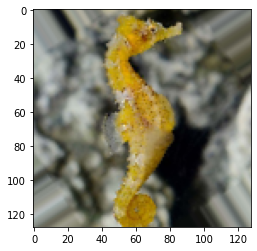

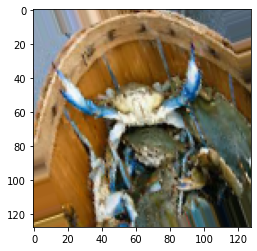

In [132]:
for _ in range(1):
    el = train_generator.next()
    batch=el[0]
    img = batch[0]
    plt.imshow(img)
    plt.show()
    img = batch[1]
    plt.imshow(img)
    plt.show()    

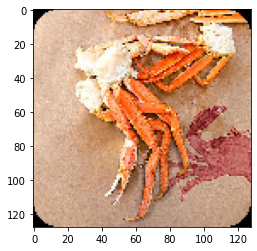

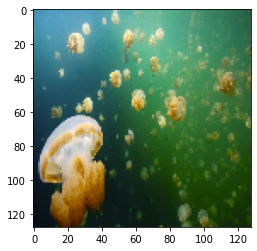

In [134]:
for _ in range(1):
    el = validation_generator.next()
    batch=el[0]
    img = batch[0]
    plt.imshow(img)
    plt.show()
    img = batch[1]
    plt.imshow(img)
    plt.show()    

## Формирование структуры сети

Немного поменяем структуру модели: увеличим количество слоев, изменм алгоритм инициализации весов, введем регуляризацию

In [139]:
import math
mymodel = Sequential(name='my')
mymodel.add(Conv2D(16, (5, 5), input_shape=(pref_size[0], pref_size[1], 3), activation='relu'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=1))
mymodel.add(Conv2D(16, (5, 5),activation='relu'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=1))

mymodel.add(Conv2D(128, (3, 3),activation='relu', padding='valid'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=2))
mymodel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
mymodel.add(Dropout(0.1))

mymodel.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=2))
mymodel.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
mymodel.add(Dropout(0.1))

mymodel.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=2))
mymodel.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
mymodel.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'))
mymodel.add(Dropout(0.1))

mymodel.add(Flatten())
mymodel.add(Dense(1024, activation='relu'))
mymodel.add(Dropout(0.1))
mymodel.add(Dense(512, activation='relu'))
mymodel.add(Dropout(0.1))
mymodel.add(Dense(number_of_classes, activation='softmax'))

mymodel.summary()

Model: "my"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_261 (Conv2D)         (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d_214 (MaxPooli  (None, 123, 123, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_262 (Conv2D)         (None, 119, 119, 16)      6416      
                                                                 
 max_pooling2d_215 (MaxPooli  (None, 118, 118, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_263 (Conv2D)         (None, 116, 116, 128)     18560     
                                                                 
 max_pooling2d_216 (MaxPooli  (None, 58, 58, 128)      0        

In [140]:
# mymodel.compile(optimizer='rmsprop', 
#               loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
#               metrics=['accuracy'])
mymodel.compile(optimizer='rmsprop', 
              loss=keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

Возможно использовать различные оптимизаторы kers:

**SGD** − Stochastic gradient descent optimizer.
`keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)`

**RMSprop** − RMSProp optimizer.
`keras.optimizers.RMSprop(learning_rate = 0.001, rho = 0.9)`

**Adagrad** − Adagrad optimizer.
`keras.optimizers.Adagrad(learning_rate = 0.01)`

**Adadelta** − Adadelta optimizer.
`keras.optimizers.Adadelta(learning_rate = 1.0, rho = 0.95)`

**Adam** − Adam optimizer.
```
keras.optimizers.Adam(
   learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
)
```

**Adamax** − Adamax optimizer from Adam.
`keras.optimizers.Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)`

**Nadam** − Nesterov Adam optimizer.
`keras.optimizers.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)`

In [137]:
mymodel.evaluate(validation_generator)

3/3 [==============================] - 1s 244ms/step - loss: 1.6100 - accuracy: 0.2444


[1.6099770069122314, 0.24444444477558136]

In [141]:
history = mymodel.fit(train_generator, validation_data=validation_generator, epochs=150)


Epoch 1/150
16/16 [==============================] - 8s 249ms/step - loss: 1.6172 - accuracy: 0.1569 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/150
16/16 [==============================] - 4s 241ms/step - loss: 1.6113 - accuracy: 0.1882 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/150
16/16 [==============================] - 5s 294ms/step - loss: 1.6113 - accuracy: 0.1725 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 4/150
16/16 [==============================] - 4s 239ms/step - loss: 1.6112 - accuracy: 0.1647 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 5/150
16/16 [==============================] - 4s 230ms/step - loss: 1.6109 - accuracy: 0.1725 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 6/150
16/16 [==============================] - 5s 302ms/step - loss: 1.6109 - accuracy: 0.1608 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 7/150
16/16 [==============================] - 4s 236ms/step - loss: 1.6112 - accuracy: 0.1608 - val_loss: 1.6094 - val_accuracy: 0.2000

Оценим точность обученной модели

In [142]:
mymodel.evaluate(validation_generator)

3/3 [==============================] - 0s 125ms/step - loss: 1.5546 - accuracy: 0.7778


[1.5546257495880127, 0.7777777910232544]

## Визуализация истории обучения

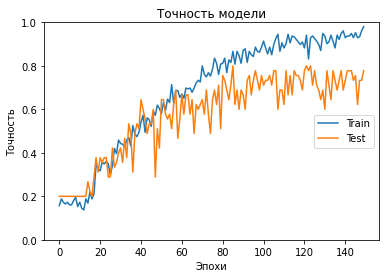

In [143]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylim(top=1.0)
plt.ylim(bottom=0.0) 
plt.ylabel('Точность')
plt.xlabel('Эпохи')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

In [144]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


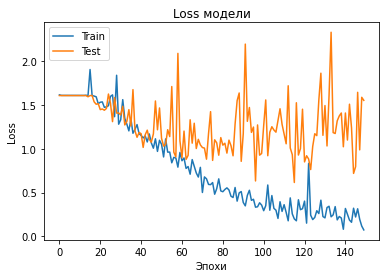

In [145]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss модели')
plt.ylabel('Loss')
plt.xlabel('Эпохи')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Тестирование модели

Рассмотрим, каким образом будет выполнена классификация для изображений, не содержащихся в обучающих выборках

In [62]:
!wget -qq https://github.com/enikolaev/ML_and_NN/raw/main/data/sea_animals_testing.zip
!mkdir testing
!unzip -q 'sea_animals_testing.zip' -d testing/test
!rm sea_animals_testing.zip
!ls testing/test

testing_crab_1.jpg  testing_goldfish_1.jpg   testing_seahorse_1.jpg
testing_crab_2.jpg  testing_jallyfish_1.jpg


In [146]:
testing_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0)
testing_data = testing_datagen.flow_from_directory('testing',
    target_size=pref_size,
    class_mode=None,
    batch_size=1,
    subset="training")

Found 5 images belonging to 1 classes.


In [147]:
prediction = mymodel.predict(testing_data)
prediction

5/5 [==============================] - 0s 14ms/step


array([[9.98769581e-01, 5.51760713e-05, 9.97235247e-07, 9.35315678e-04,
        2.38934037e-04],
       [3.68042583e-06, 4.61019267e-09, 1.02660215e-11, 9.99995828e-01,
        4.43690340e-07],
       [5.20918703e-13, 9.99891043e-01, 1.83015613e-17, 1.08961001e-04,
        3.77420636e-14],
       [4.36946191e-02, 5.92133962e-04, 3.07083319e-05, 9.54998970e-01,
        6.83517545e-04],
       [3.69593973e-11, 4.14662527e-09, 9.99825537e-01, 1.70548679e-04,
        3.89846991e-06]], dtype=float32)

1/1 [==============================] - 0s 22ms/step
seahorse [3.68042583e-06 4.61019267e-09 1.02660215e-11 9.99995828e-01
 4.43690340e-07]


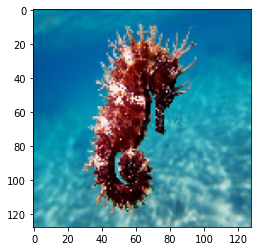

1/1 [==============================] - 0s 25ms/step
crab [9.9876958e-01 5.5176071e-05 9.9723525e-07 9.3531568e-04 2.3893404e-04]


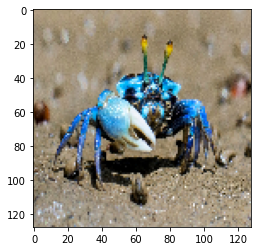

1/1 [==============================] - 0s 24ms/step
seahorse [4.3694619e-02 5.9213396e-04 3.0708332e-05 9.5499897e-01 6.8351754e-04]


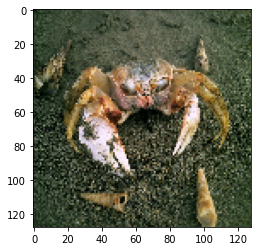

1/1 [==============================] - 0s 23ms/step
jellyfish [3.6959397e-11 4.1466253e-09 9.9982554e-01 1.7054868e-04 3.8984699e-06]


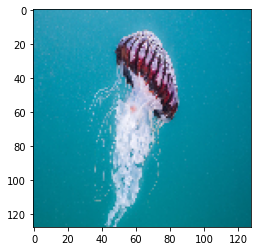

1/1 [==============================] - 0s 36ms/step
seahorse [3.68042583e-06 4.61019267e-09 1.02660215e-11 9.99995828e-01
 4.43690340e-07]


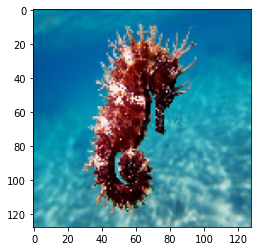

In [184]:
for _ in range(5):
    b = testing_data.next()
    img=b[0]
    pred = mymodel.predict(np.expand_dims(img, axis=0))
    pred_label = labels[np.argmax(pred[0])]
    print( pred_label, pred[0] )
    plt.imshow(img)
    plt.show()

## Выводы

Построенный классификатор нуждается в доработке. Внимательно изучите кривые обучения и ответьте на вопрос: что происходит с моделью и как называется подобное состояние модели. Выработайте рекомендации по улучшению модели

## Задание

Используя представленный Python Notebook обеспечить повышение качества модели сверточной нейронной сети за счет следующих стратегий:

* применение стратегий dropout различной агрессивности
* применение различных алгоритмов инициализации весов CNN
* применение различных стратегий регуляризации
* разработка более эффективных архитектур нейронных сетей (добавляйте и удаляйте слои, применяйте различные стратегии свертки)
* использование различных функций активации
* исследуйте различные алгоритмы обучения